In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:

import utils.data_util
import pandas as pd
import warnings

warnings.filterwarnings('ignore')


from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset


### Data loading

In [7]:
data = pd.read_pickle('/content/gdrive/MyDrive/eld_filtered_labled.pkl')
data = data.drop('day_of_week',axis=1)
#Choosing a customer
data_clients = data.drop('Consumption',axis=1)

data_M300 = data[['MT_300']]
data_M300= data_M300.resample(rule='24H', closed='left', label='left', base=17).sum()
data_M300['value'] = data_M300['MT_300']
data_M300 = data_M300.drop('MT_300',axis =1)

<AxesSubplot:title={'center':'Electrical load consumption MT_300'}, xlabel='Date'>

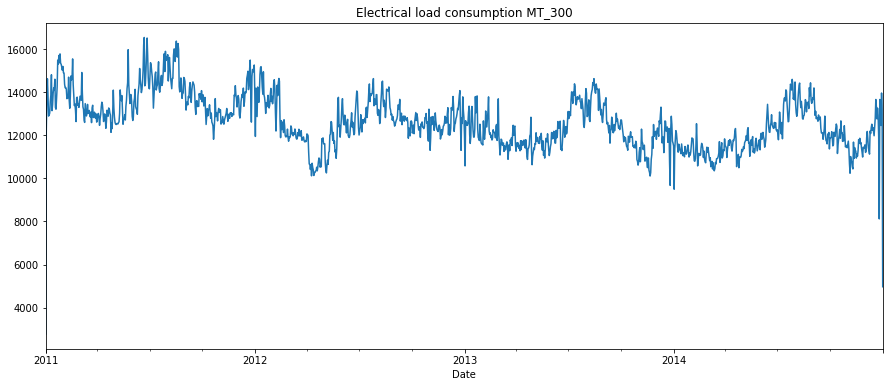

In [8]:
data_M300.plot(figsize = (15, 6), title = 'Electrical load consumption MT_300', legend = False)

### Preprocessing

In [9]:
from sklearn import preprocessing 
scaler = preprocessing.RobustScaler(quantile_range=(25, 75))
train, test = data_util.split(data_M300, data_M300.columns[0], scaler=scaler, test_size=0.25) #0.05

Train_shape:  (1096, 1)
Test_shape:  (366, 1)
Data Standardization with  RobustScaler(quantile_range=(25, 75))


In [10]:
col_name = data_M300.columns[0]
n_steps = 30
X_train, y_train = data_util.create_dataset(train[[col_name]], train[col_name], n_steps)
X_test, y_test = data_util.create_dataset(test[[col_name]], test[col_name], n_steps)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)
print("-------------------")



X_train shape: (1066, 30, 1)
X_test shape: (336, 30, 1)
y_train shape: (1066,)
y_test shape: (336,)
-------------------


### Model defination

In [13]:
from typing import Tuple
from tensorflow import keras
from keras.layers import LSTM, Dropout, RepeatVector, TimeDistributed, Dense
from tensorflow import keras
import model.keras_lstm_ae
    
def create_lstm_ae(input_shape: Tuple[int, ...],
                  units: int = 64,
                  activation: str = 'relu',
                  dropout: float = 0.2
                 ) -> keras.Model:
    # define model
    (n_timesteps, n_features) = input_shape
    inputs = keras.Input(shape=input_shape)
    z = inputs
    z = LSTM(units = units)(z)
    z = Dropout(rate=dropout)(z)
    z = RepeatVector(n_timesteps)(z)
    z = LSTM(units=units, return_sequences=True)(z)
    z = Dropout(rate=dropout)(z)
    z = TimeDistributed(Dense(units = n_features))(z)
    return keras.Model(inputs=inputs, outputs=z, name="lstm_ae_model")

In [17]:


n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]
units = 64
dropout = 0.2
loss = 'mae'
optimizer = 'adam'


model = keras_lstm_ae.create_lstm_ae(input_shape=(n_timesteps, n_features), dropout=dropout, units=units)
model.compile(loss = loss, optimizer = optimizer)
model.summary()



Model: "lstm_ae_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 repeat_vector (RepeatVector  (None, 30, 64)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 30, 64)            33024     
                                                                 
 dropout_1 (Dropout)         (None, 30, 64)            0         
                                                     

### Training

In [18]:


history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')], shuffle=False) #X_train



Epoch 1/60
30/30 [==============================] - 10s 33ms/step - loss: 0.3607 - val_loss: 0.3455
Epoch 2/60
30/30 [==============================] - 0s 8ms/step - loss: 0.3398 - val_loss: 0.3378
Epoch 3/60
30/30 [==============================] - 0s 8ms/step - loss: 0.3274 - val_loss: 0.3356
Epoch 4/60
30/30 [==============================] - 0s 8ms/step - loss: 0.3287 - val_loss: 0.3349
Epoch 5/60
30/30 [==============================] - 0s 8ms/step - loss: 0.3281 - val_loss: 0.3342
Epoch 6/60
30/30 [==============================] - 0s 8ms/step - loss: 0.3265 - val_loss: 0.3340
Epoch 7/60
30/30 [==============================] - 0s 8ms/step - loss: 0.3256 - val_loss: 0.3336
Epoch 8/60
30/30 [==============================] - 0s 8ms/step - loss: 0.3270 - val_loss: 0.3345
Epoch 9/60
30/30 [==============================] - 0s 8ms/step - loss: 0.3257 - val_loss: 0.3327
Epoch 10/60
30/30 [==============================] - 0s 8ms/step - loss: 0.3252 - val_loss: 0.3329
Epoch 11/60
30/30

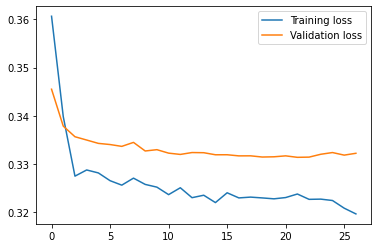

In [19]:


from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='Training loss')
pyplot.plot(history.history['val_loss'], label='Validation loss')
pyplot.legend();



In [20]:


model.evaluate(X_test, y_test)



11/11 [==============================] - 0s 4ms/step - loss: 0.2846


0.28461867570877075

### Threshold calculation

Training loss:  0.3035995594072351

Reconstruction error threshold: 0.7643668088030293


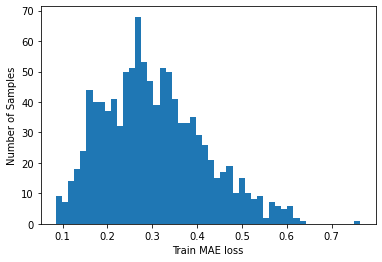

In [21]:


# CALCULATING THRESHOLD (WAY1)

import numpy as np
X_train_pred = model.predict(X_train, verbose=0)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)
avg_loss = train_mae_loss.mean()
print("Training loss: ", avg_loss); print()

pyplot.hist(train_mae_loss, bins=50)
pyplot.xlabel('Train MAE loss')
pyplot.ylabel('Number of Samples');

threshold = np.max(train_mae_loss)
print(f'Reconstruction error threshold: {threshold}')



In [22]:
import math
import sklearn
# MAE on the test data:
X_test_pred = model.predict(X_test)
print('Predict shape (X_test_pred):', X_test_pred.shape); print();
mae = np.mean(np.abs(X_test_pred - X_test), axis=1)
# reshaping prediction
pred = X_test_pred.reshape((X_test_pred.shape[0] * X_test_pred.shape[1]), X_test_pred.shape[2])
print('Prediction:', pred.shape); print();
print('Test data shape (X_test):', X_test.shape); print();
# reshaping test data
X_test_reshape = X_test.reshape((X_test.shape[0] * X_test.shape[1]), X_test.shape[2])
print('Test data (X_test_reshape):', X_test_reshape.shape); print();
# error computation
errors = X_test_reshape - pred
print('Error:', errors.shape); print();
# rmse on test data
RMSE = math.sqrt(sklearn.metrics.mean_squared_error(X_test_reshape, pred))
print('Test RMSE: %.3f' % RMSE);

11/11 [==============================] - 0s 3ms/step
Predict shape (X_test_pred): (336, 30, 1)

Prediction: (10080, 1)

Test data shape (X_test): (336, 30, 1)

Test data (X_test_reshape): (10080, 1)

Error: (10080, 1)

Test RMSE: 0.352


0.13750144385694404 0.5490386512061998


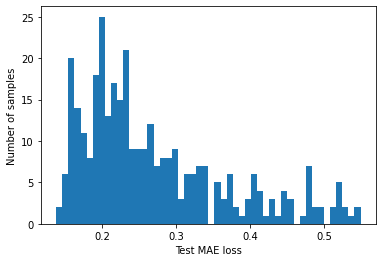

In [23]:
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

pyplot.hist(test_mae_loss, bins=50)
pyplot.xlabel('Test MAE loss')
pyplot.ylabel('Number of samples');
print(np.min(test_mae_loss), np.max(test_mae_loss))

In [24]:


# CALCULATING THRESHOLD (WAY1)
dist = np.linalg.norm(X_test_reshape - pred, axis=1)
scores = dist.copy();
print("Score", scores.shape)
scores.sort()
cut_off = int(0.9*len(scores))
print("cut_off value: ", cut_off)
threshold = 0.5
print(f'Threshold: {threshold}')



Score (10080,)
cut_off value:  9072
Threshold: 0.5


In [25]:


test_score_df = pd.DataFrame(test[n_steps:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df[data_M300.columns[0]] = test[n_steps:][data_M300.columns[0]]



### Results

In [26]:


test_score_df.tail()



,value,loss,threshold,anomaly
Date,,,,
2014-12-27 17:00:00,-0.170890,0.437254,0.5,False
2014-12-28 17:00:00,-0.182731,0.428099,0.5,False
2014-12-29 17:00:00,0.723339,0.413575,0.5,False
2014-12-30 17:00:00,0.248236,0.475281,0.5,False
2014-12-31 17:00:00,-4.690565,0.483010,0.5,False


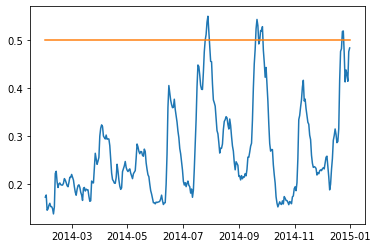

In [27]:
pyplot.plot(test_score_df['loss'])
pyplot.plot(test_score_df['threshold'])

In [29]:


anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
anomalies



,value,loss,threshold,anomaly
Date,,,,
2014-07-26 17:00:00,1.105710,0.510867,0.5,True
2014-07-27 17:00:00,0.978872,0.536777,0.5,True
2014-07-28 17:00:00,0.554805,0.549039,0.5,True
2014-07-29 17:00:00,0.643964,0.515748,0.5,True
2014-09-19 17:00:00,-0.417727,0.522997,0.5,True
2014-09-20 17:00:00,-0.280843,0.542396,0.5,True
2014-09-21 17:00:00,0.078656,0.529256,0.5,True
2014-09-24 17:00:00,-0.628276,0.519507,0.5,True
2014-09-25 17:00:00,-0.698003,0.517656,0.5,True


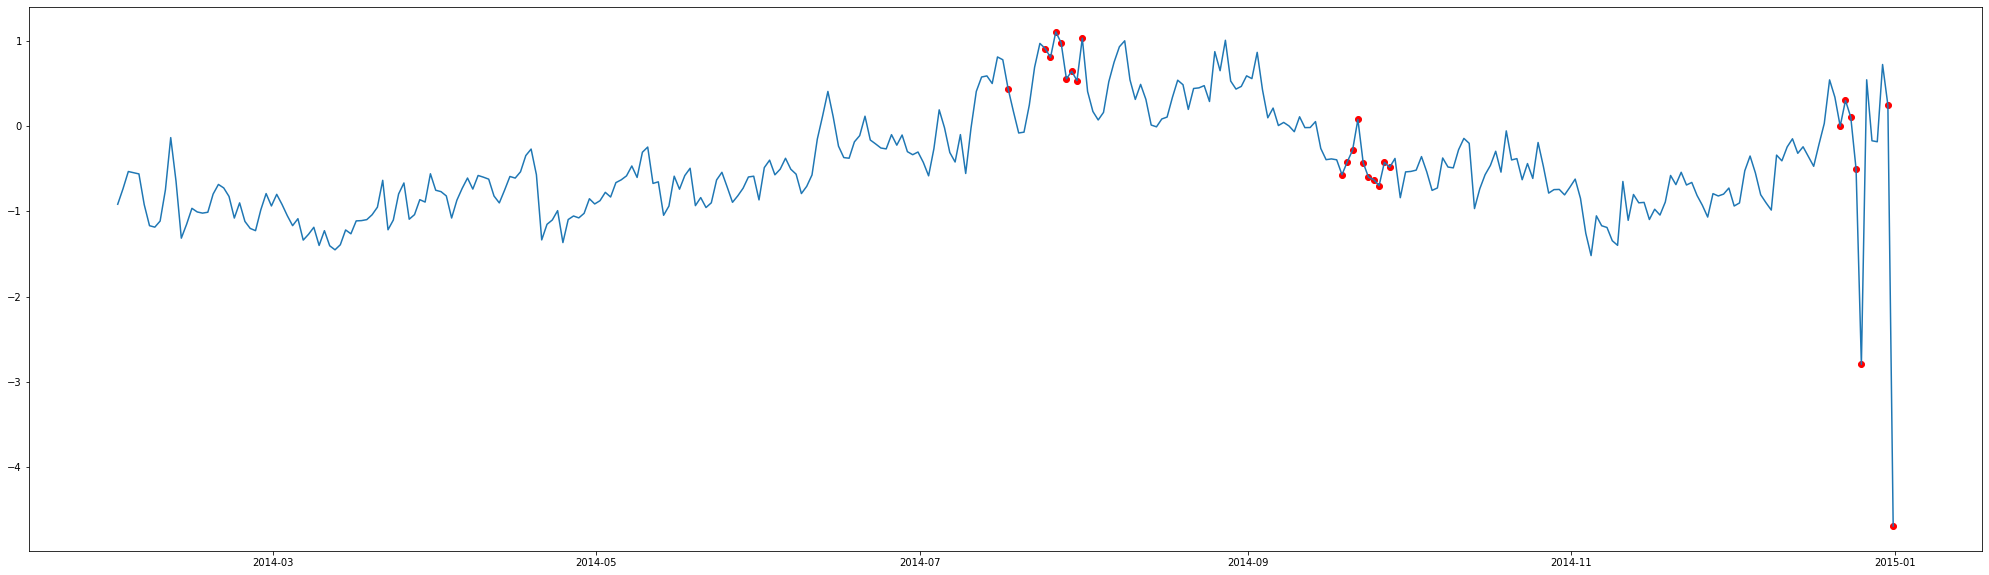

In [ ]:
pyplot.figure(figsize=(35,10))
pyplot.plot(test_score_df.index, (test_score_df[data_M300.columns[0]]))
pyplot.scatter(anomalies.index, (anomalies[data_M300.columns[0]]), marker='o', color="red")